In [150]:
import numpy as np
from astropy.table import Table
from scipy.optimize import fmin
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15 as cosmo

In [151]:
def Vmod(dt, x):
    gamma = 0.336
    dt0 = 7.05e4
    gamma_err = 0.033
    dt0_err = 4.23
    dt_rest = dt/(1+x[0])
    model = (dt_rest/dt0)**gamma / (np.pi/2.)**0.5
    #error2 = model**2 * ((gamma*dt0/dt0_err) * (np.log(dt_rest/dt0)*gamma_err)**2)
    error2 = (model*0.1)**2
    return model, error2

In [152]:
def Vmod(dt, x):
    Mi = -25 + cosmo.distmod(1.0).value - cosmo.distmod(x[0]).value
    lam_obs = 6500.
    model = 1.00*(1+0.024*Mi) * (dt/lam_obs)**0.3
    error2 = (0.1*model)**2
    return model, error2

In [153]:
def chi2(x, dt, mag_diff, mag_diff_err2):
    if x[0]<0:
        return np.inf
    V, dV2 = Vmod(dt, x)
    #dV2 = V*0.
    P1 = np.exp(-0.5*(mag_diff-V)**2/(mag_diff_err2+dV2))
    P2 = np.exp(-0.5*(mag_diff+V)**2/(mag_diff_err2+dV2))
    lP1P2 = np.log(P1+P2)
    lP1P2_use = lP1P2#[lP1P2<np.median(lP1P2)]
    return -2.*np.sum(lP1P2_use)
        

In [154]:
#Make all combinations of magnitude differences and errors.
def get_SF(lc):
    dt = list()
    mag_diff = list()
    mag_diff_err2 = list()
    for i in range(len(lc['mjd'])):
        for j in range(i+1, len(lc['mjd'])):
            dt.append(lc['mjd'][i]-lc['mjd'][j])
            mag_diff.append(lc['psMag'][i]-lc['psMag'][j])
            mag_diff_err2.append(lc['psMagErr'][i]**2+lc['psMagErr'][j]**2)
    dt = np.array(dt)
    mag_diff = np.array(mag_diff)
    mag_diff_err2 = np.array(mag_diff_err2)
    return dt, mag_diff, mag_diff_err2

In [155]:
fnames = [
    "object1415792.dat",
    "object1444606.dat",
    "object1464480.dat",
    "object1465497.dat",
]

In [156]:
fname = fnames[1]
lc = Table.read(fname, format='ascii')
lc.sort('mjd', reverse=True)

dt, mag_diff, mag_diff_err2 = get_SF(lc)

In [157]:
chi2([1.0], dt, mag_diff, mag_diff_err2)

15679.703093123406

In [158]:
V, dV2 = Vmod(dt, [1.0])
print(np.min(V), np.max(V), np.min(dV2), np.max(dV2))
P1 = np.exp(-0.5*(mag_diff-V)**2/(mag_diff_err2+dV2))
P2 = np.exp(-0.5*(mag_diff+V)**2/(mag_diff_err2+dV2))
print(np.min(P1), np.max(P1), np.min(P2), np.max(P2))

0.02837052380484798 0.276570960962313 8.048866209614461e-06 0.0007649149644761726
3.655684856355007e-92 0.9999866960775704 7.7210504321492706e-205 0.9999915899886639


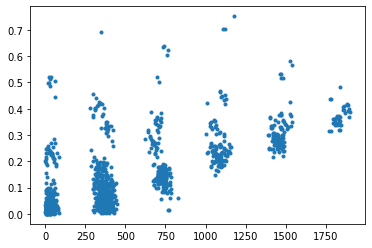

In [159]:
plt.plot(dt, np.abs(mag_diff), '.')

[1.0] 9540.686494207377
Optimization terminated successfully.
         Current function value: 6456.938648
         Iterations: 20
         Function evaluations: 40
[0.04423828] 6456.938648113202


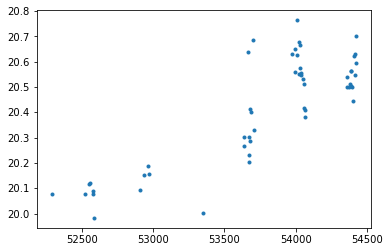

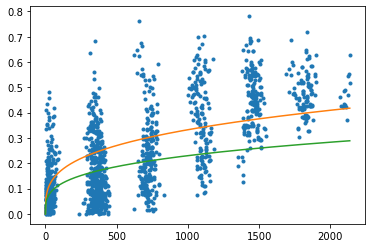

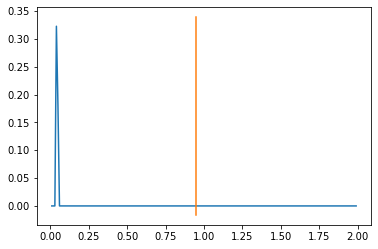

[1.0] 15679.703093123406
Optimization terminated successfully.
         Current function value: 15677.714311
         Iterations: 11
         Function evaluations: 22
[0.95546875] 15677.71431138595


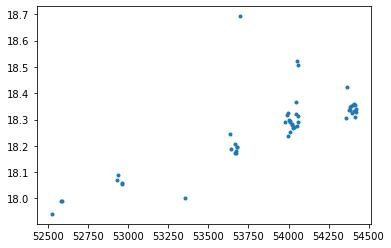

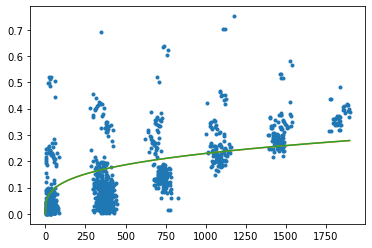

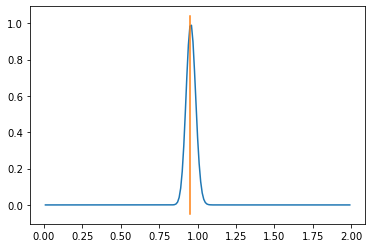

[1.0] 38174.604600805586
Optimization terminated successfully.
         Current function value: 33141.122693
         Iterations: 22
         Function evaluations: 44
[8.50117188] 33141.12269271554


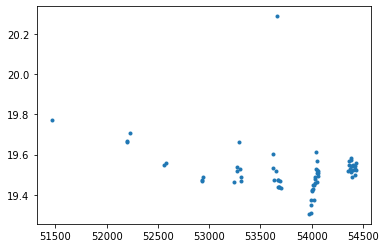

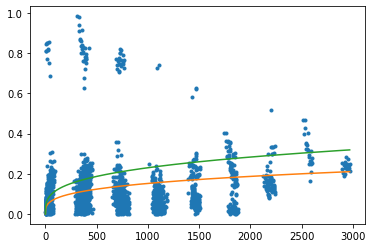

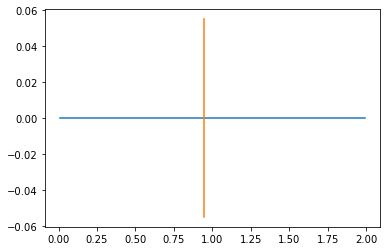

[1.0] 4447.235214443306
Optimization terminated successfully.
         Current function value: 4393.939851
         Iterations: 16
         Function evaluations: 32
[1.78759766] 4393.939850601869


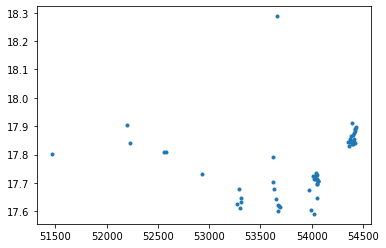

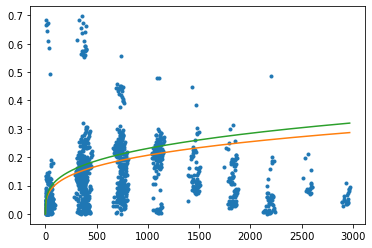

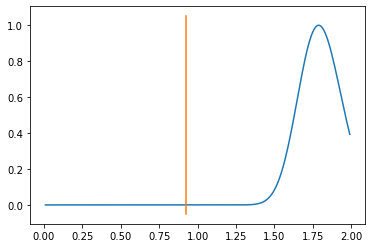

In [160]:
for fname in fnames:
    lc = Table.read(fname, format='ascii')
    lc.sort('mjd', reverse=True)

    dt_all, mag_diff_all, mag_diff_err2_all = get_SF(lc)
    cond = dt_all>0 #dt_all < 1000.
    dt = dt_all[cond]
    mag_diff = mag_diff_all[cond]
    mag_diff_err2 = mag_diff_err2_all[cond]

    z_guess = 1.0
    x0 = [z_guess]
    print(x0, chi2(x0, dt, mag_diff, mag_diff_err2))
    xopt = fmin(chi2, x0, args=(dt, mag_diff, mag_diff_err2))
    print(xopt,chi2(xopt, dt, mag_diff, mag_diff_err2))

    plt.plot(lc['mjd'], lc['psMag'], '.')
    plt.show()

    plt.plot(dt, np.abs(mag_diff), '.')
    dt_mod = np.arange(0.,np.max(dt),1.0)
    plt.plot(dt_mod, Vmod(dt_mod, xopt)[0])
    plt.plot(dt_mod, Vmod(dt_mod, [lc['z'][0]])[0])
    plt.show()

    zs = np.arange(0.01, 2.0, 0.01)
    chi2_z = np.zeros(zs.shape)
    for k, z in enumerate(zs):
        chi2_z[k] = chi2([z], dt, mag_diff, mag_diff_err2)
    chi2_z -= chi2(xopt, dt, mag_diff, mag_diff_err2)
    plt.plot(zs, np.exp(-0.5*chi2_z))
    plt.ylim()
    plt.plot([lc['z'][0], lc['z'][0]], plt.ylim())
    plt.show()